# The Computational Image of the City: Nodes, Paths and Districts

In [2]:
import networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import community
import matplotlib.pyplot as plt
from importlib import reload
import geopandas as gpd
import functools
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import urbanFormPy as up

## Important:
## find EPSG of your case-study area
### Specify the name of the city for convenience

In [34]:
#initialise path, names, etc.

city_name = 'York'
saving_path ='Outputs/'+city_name+'/'
epsg = 2019
crs = {'init': 'epsg:2019', 'no_defs': True}

1 or 2 street networks (SN) may be needed when the case study is a particular urban area (UA).

#### Option 1 ------------
Only one graph is used (*graphA*): It includes the SN of UA and its surroundigraphA (e.g. buffer of 2000 mt) and it is used for computing centrality measures as well as for districts identification. Paths, nodes and districts are extracted from *graphA* by clipping them from the polygon representing UA extension. A large network is employed so as to prevent the edge-effect when computing centrality measures.

#### Option 2 ------------
Two graphs are used: *graphA* as above, plus a second one, *graphB* even more extended than the first, for a more precise districts extraction. Paths and nodes are extracted from *graphA*, districts from *graphB*.

In [7]:
# choose the method and specify how the graph is obtained

option_1 = True
option_2 = False

### Using shapefiles
#### Replace directories with your path, in case you are using local shapefiles

In [10]:
# provide files' directories and loading the data

# the polygon is not strictly necessary. It is needed when clipping the Street Network
path_polygon = None # specify path here - 
path_graphA = 'York_roads.shp'
    
# Leave None for attributes not contained in the dataframe or for attributes of no interest.
dict_columns = {"roadType_field": "type",  "direction_field": "oneway", "speed_field": None, "name_field": "name"}

"""""
to avoid edge effect when computing betweennes centrality values. If you are using already a network a bit larger
then you are case-study are, set "distance_from_boundary" to 0.  

"radius" is used only when the case_study_area_polygon is not provided, to define an optional clipping buffer 

"fix_topology" breaks lines at intersections with other lines in the streets GeoDataFrame, 
    apart from segments categorised as bridges in OSM
"""""

if option_1:
    if path_polygon != None: case_study_area = gpd.read_file(path_polygon).iloc[0].geometry
    else: case_study_area = None
    nodes_graphA, edges_graphA = up.get_network_fromSHP(path_graphA, epsg, case_study_area = case_study_area, 
                                        radius = 0, dict_columns = dict_columns, fix_topology = True)

elif option_2:
    nodes_graphA, edges_graphA = up.get_network_fromSHP(path_graphA, epsg, crs,  case_study_area = case_study_area, 
                                                        distance_from_center = 0, dict_columns = dict_columns)
    nodes_graphB, edges_graphB =  up.get_fromSHP(path_graphB, epsg, crs, distance_from_center = 0)

## Cleaning and simplyfing the Street Network - gdf

At the end of the previous section two files are obtained: nodes and edges (vertexes, or links). Below, before creating the actual graph, the two datasets are cleaned, simplified and corrected.

Cleaning functions handle:
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* Disconnected islands.
* Dead-ends (optional).

In [11]:
"""
- Turn on "update_densities" if you have flows/mobility densities or any other count associated to each edge. 
Please provide the corresponding column_name if this is the case.
- "same_uv_edges" regulates the handling of edges with same pair of u-v nodes but different geometries.
When true keeps a center line between the two segments, unless one of the two segments is significantly longer than 
the other (>30%). In this case, the longer segment is deleted.
"""
nodes_graphA, edges_graphA = up.clean_network(nodes_graphA, edges_graphA, dead_ends = False, 
                            remove_disconnected_islands = True, same_uv_edges = True)

Done after  1  cleaning cycles


In [6]:
# cleaning and simplifying large network as well
if option_2:
    nodes_graphB, edges_graphB = up.clean_network(nodes_graphA, edges_graphA, dead_ends = False, 
                        remove_disconnected_islands = True, same_uv_edges = False)

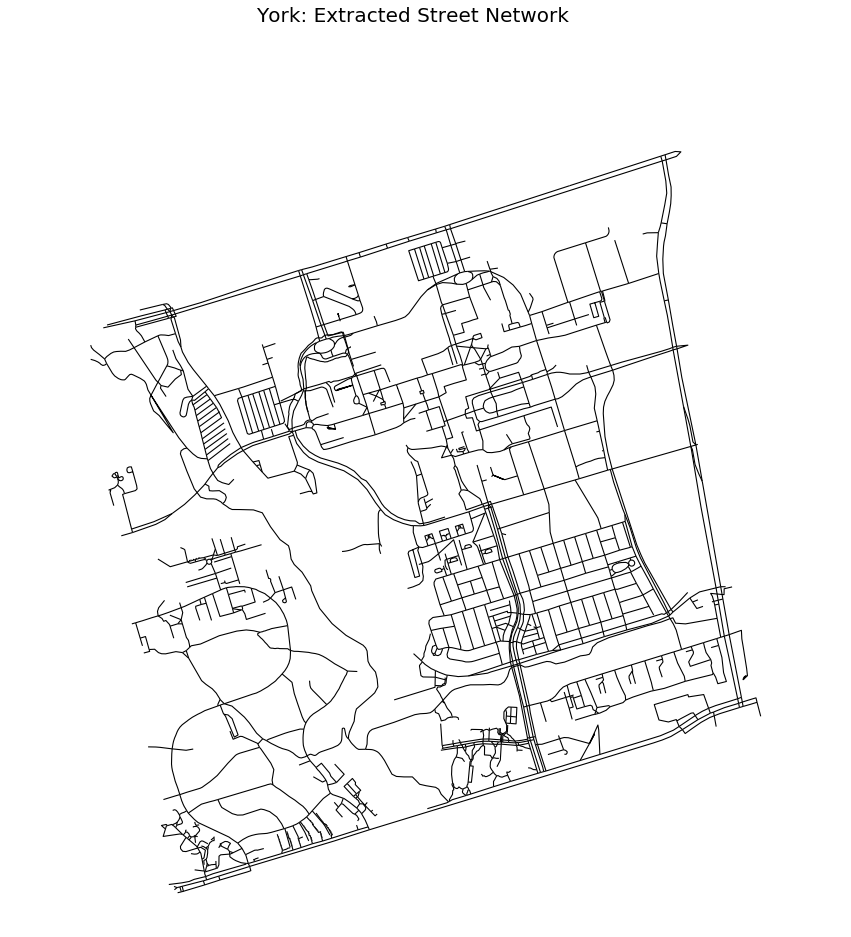

In [35]:
up.plot_lines(edges_graphA, scheme = None,
              black_background = False, fig_size = 15, title = city_name+': Extracted Street Network')

In [15]:
edges_graphA.to_file(saving_path+city_name+"_edges_corrected.shp",driver = 'ESRI Shapefile')
nodes_graphA.to_file(saving_path+city_name+"_nodes_corrected.shp", driver = 'ESRI Shapefile')

In [21]:
# obtaining graph from the case-study area 
graphA = up.graph_fromGDF(nodes_graphA, edges_graphA)

## Indexes computation - Nodes

On the primal graph representation of the street network, the following centrality measures are computed on nodes, on the basis of the street segment lenght (road distance):
* Betweenness centrality.
* Information centrality.
* Straightness centrality (see [Crucitti et al. 2006](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.73.036125)).
* Reach centrality (readataped from [Sevtsuk & Mekonnen 2012](https://www.sutd.edu.sg/cmsresource/idc/papers/2012_Urban_Network_Analysis_A%20New%20Toolbox_for_ArcGIS.pdf)) - it measures the importance of a node based on the number of services (e.g. commercial activities) reachable by that node (for instance within a buffer). For this purpose a "services" shapefile has to be loaded
* Local centrality measures (slow).

### Global Centrality measures

In [31]:
"""
"measure" accepts "betweenness_centrality", "information_centrality", "straightness_centrality", "closeness_centrality".
The function returns dictionaries, which are going to be merged in the GDF below.
"""
# betweenness centrality
Bc_Eu = up.centrality(graphA, measure = "betweenness_centrality", weight = 'length', normalized = False)
# information centrality
# Bc_Rw =  up.centrality(graphA, measure = "information_centrality", weight = 'length', normalized = False)
# straightness centrality
Sc = up.centrality(graphA, measure = "straightness_centrality", weight = 'length', normalized = False)

In [ ]:
# reach centrality pre-computation, in relation to Point of Interests or any other point-geodataframes 
services = (gpd.read_file(None)).to_crs(epsg=epsg)

# using a 50 mt radius to look for services and weight the nodes
graphA = up.weight_nodes(nodes_graphA, services, graphA, name = 'services', radius = 50)
      
# Reach Centrality
Rc400 = up.reach_centrality(graphA, weight = 'length', radius = 400, attribute = 'services') 
Rc600 = up.reach_centrality(graphA, weight = 'length', radius = 600, attribute = 'services')

#### Saving the attributes in the geodataframe

In [32]:
col = [Bc_Eu, Sc]
names = ['Bc_Eu', 'Sc']
nodes_df = up.dict_to_df(col, names)
nodes = pd.merge(nodes_graphA, nodes_df, left_on = "nodeID", right_index = True, how = 'left')

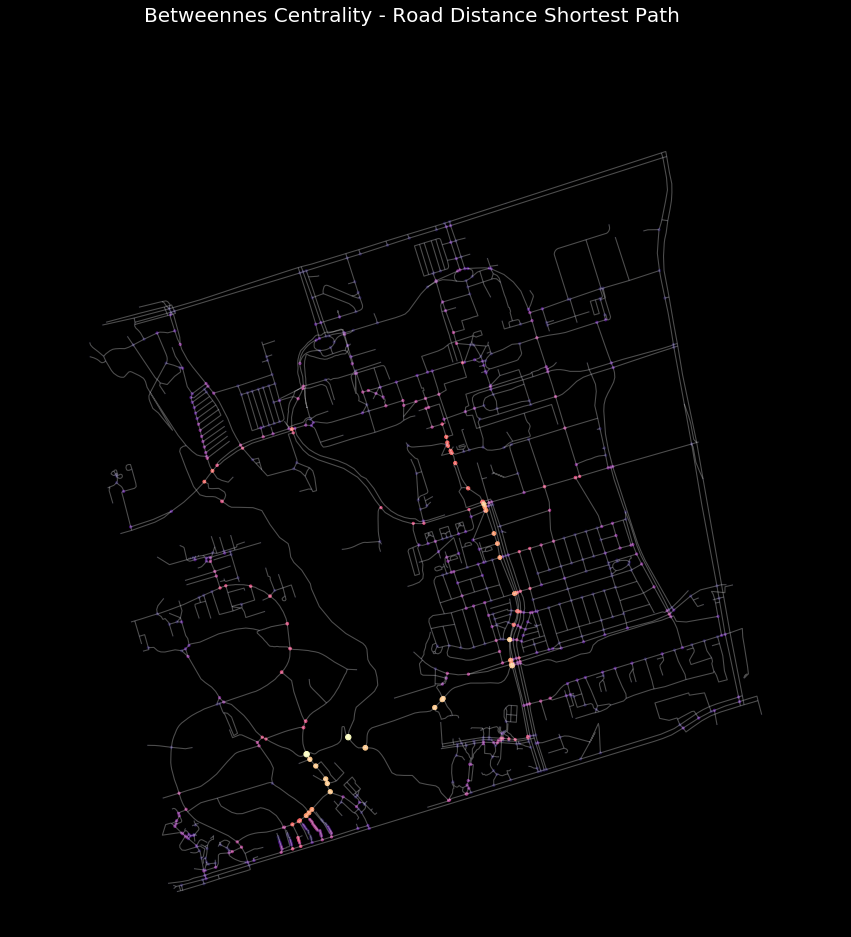

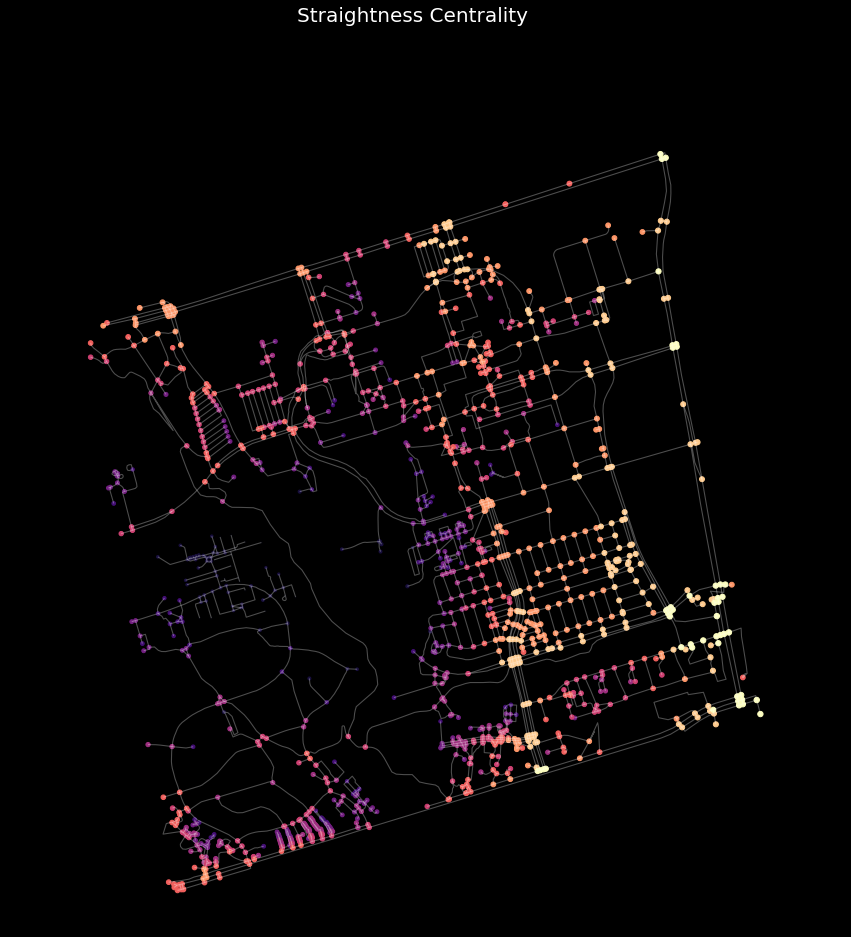

In [21]:
"""
Indicate if you want legend or color bar; colr_map, number of classes and scheme. Check the function in plotting.py for 
further parameters. You can pass the edges GeoDataFrame as the argument of "background" if you wish to have a base map 
(works with any LineString or Polygon GeoDataFrames).
"""
col = ['Bc_Eu', 'Sc']
title = ['Betweennes Centrality - Road Distance Shortest Path', 'Straightness Centrality']

for n, i in enumerate(col):
    tmp = nodes.copy()
    up.scaling_columnDF(tmp, i)
#     visualising by passing a series of markersize values (ms) 
    tmp['ms'] = np.where(tmp[i+'_sc'] >= 0.20, tmp[i+'_sc']*30, 5) # marker size
    up.plot_points(tmp, column = i, classes = 10, ms_col = 'ms', title = title[n], cmap = 'magma', fig_size = 15,
                   gdf_base_map = edges_graphA)

### Local Centrality measures

In [ ]:
# """
# "measure" accepts "betweenness_centrality", "straightness_centrality", "closeness_centrality".
# Please provide radius. The computation may require a lot of time.
# """
# Bc_200 = up.local_centrality(graphA, measure = "betweenness_centrality", weight = "length", radius = 200, normalized = False)
# Bc_400 = up.local_centrality(graphA, measure = "betweenness_centrality", weight = "length", radius = 400, normalized = False)

In [ ]:
# col = [Bc_200, Bc_400]
# names = ["Bc_200", "Bc_400"]
# nodes_df = up.dict_to_df(col, names)
# nodes = pd.merge(nodes, nodes_df, left_on = "nodeID", right_index = True, how = 'left')

In [ ]:
# col = ["Bc_200", "Bc_400"]
# title = ["Local Betweennes Centrality - 400 mt Radius", "Local Betweennes Centrality - 600 mt Radius" ]

# for n, i in enumerate(col):
#     tmp = nodes.copy()
#     up.scaling_columnDF(tmp, i)
# #     visualising by passing a series of markersize values (ms) 
#     tmp['ms'] = np.where(tmp[i+'_sc'] >= 0.20, tmp[i+'_sc']*32, 0.40) # marker size
#     up.plot_points(tmp, column = i, classes = 10, ms_col = 'ms', title = title[n], cmap = 'magma', fig_size = 15,
#                    gdf_base_map = edges_graphA)

### Saving the area of interest for external uses (e.g. simulation)

## Paths

On the primal graph representation of the street network, the following centrality measures are computed on edges:
* Road Distance Betweenness centrality.
* Angular Betweenness centrality (On the dual graph representation of the street network)

In [22]:
# Euclidean betweenness centrality
Eb = nx.edge_betweenness_centrality(graphA, weight = 'length', normalized = False)

In [23]:
# creating geodataframe
edgesID = {}
for i, g in graphA.edges(): edgesID[(i,g)] = graphA[i][g]['edgeID']

col = [Eb, edgesID]
names = ['Eb', 'edgeID']

edges_df = up.dict_to_df(col, names)
edges_df.edgeID = edges_df.edgeID.astype(int)
edges_tmp = pd.merge(edges_graphA, edges_df, on = 'edgeID', how = 'left')
edges_tmp.index = edges_tmp.edgeID
del edges_tmp.index.name

In [24]:
t = [ item for item in list(edges_graphA.index) if item not in list(edgesID.values())]
for i in t: edges_tmp.at[i, 'Eb'] = 0

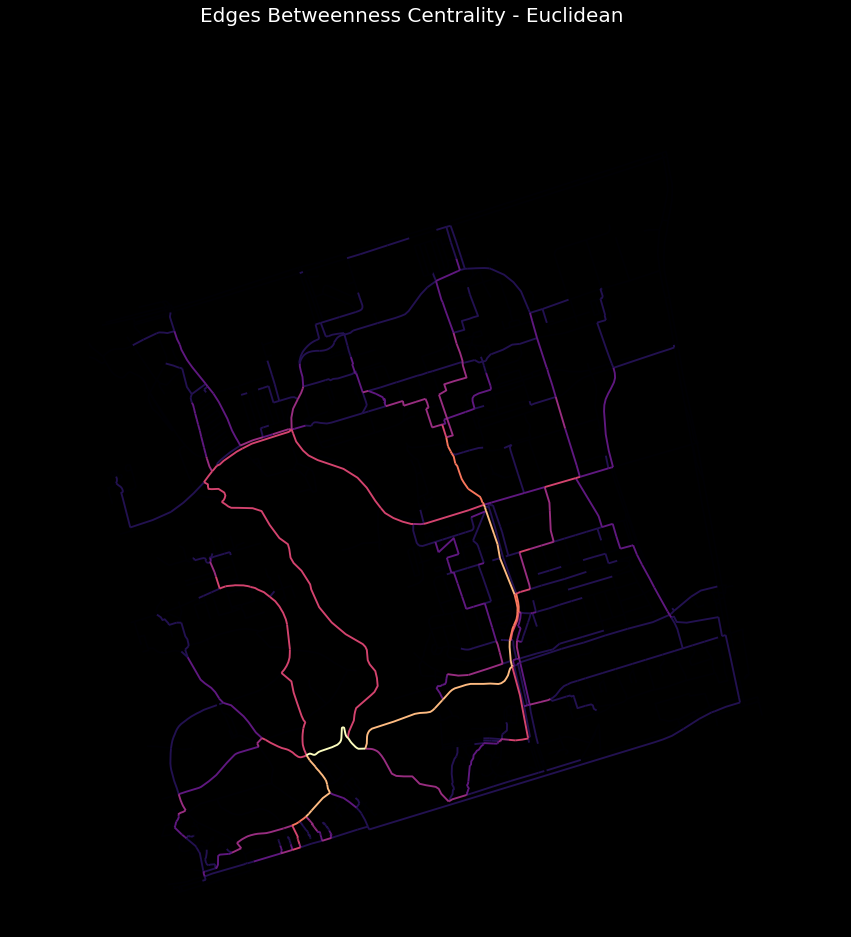

In [78]:
# visualising
up.scaling_columnDF(edges_tmp, "Eb")
up.plot_lines(edges_tmp, classes = 8, column = 'Eb_sc', title = 'Edges Betweenness Centrality - Euclidean', lw = 1.9, 
              scheme = 'Natural_Breaks', cmap = 'magma', fig_size =15)

## Dual graph analysis

Here street-segments are transformed into nodes (geograpically represented by their centroids). Fictional links represent instead intersections. Thus if two segments are connected in the actual street network, a link in the dual graph representation will be created by connecting the corresponding nodes. 
This process allows to take advantage of angular relationships in centrality measures computation and other network operations.

In [18]:
# Creating the dual geodataframes and the dual graph.
nodesDual_graphA, edgesDual_graphA = up.dual_gdf(nodes_graphA, edges_graphA, epsg)
DGa = up.dual_graph_fromGDF(nodesDual_graphA, edgesDual_graphA)

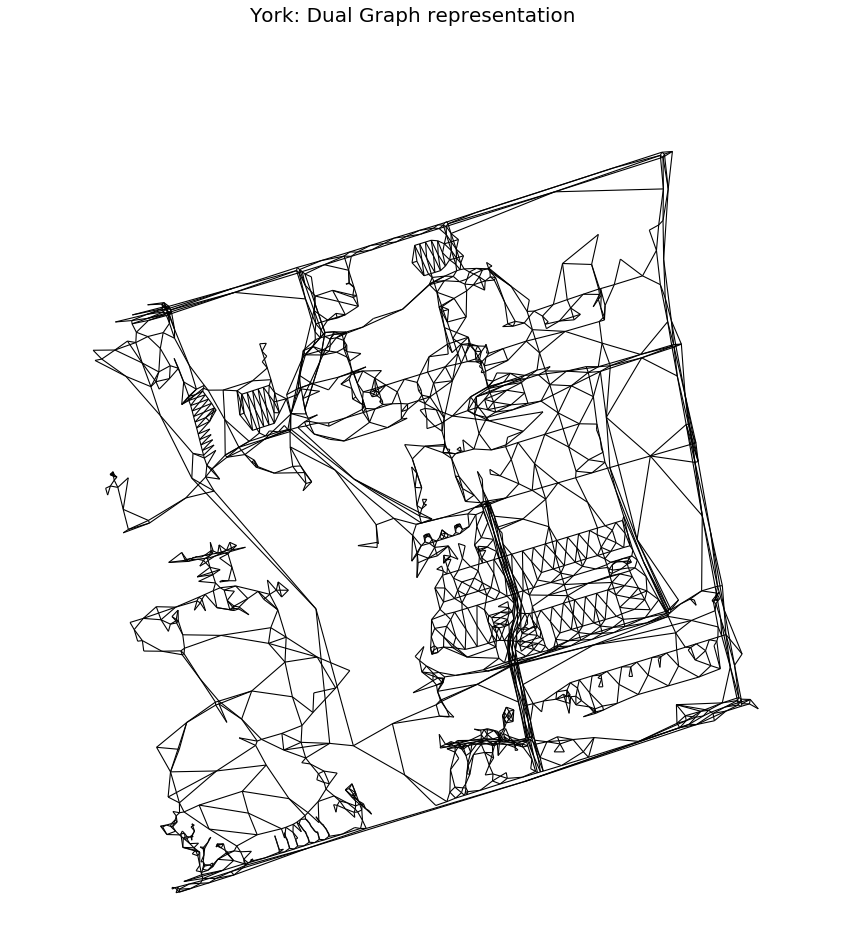

In [36]:
up.plot_lines(edgesDual_graphA, scheme = None,
              black_background = False, fig_size = 15, title = city_name+': Dual Graph representation')

## Angular Betweenness - Paths

In [25]:
# Angular-change betweenness centrality
Ab = nx.betweenness_centrality(DGa, weight = 'rad', normalized = False)
Ab_dict = up.dual_id_dict(Ab, DGa, 'edgeID')
Ab_df = up.dict_to_df([Ab_dict], ['Ab'])
edges = pd.merge(edges_tmp, Ab_df, left_on = "edgeID", right_index = True, how = 'left')

C:\Users\g_filo01\AppData\Local\Continuum\miniconda3\envs\cityImage\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\g_filo01\AppData\Local\Continuum\miniconda3\envs\cityImage\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


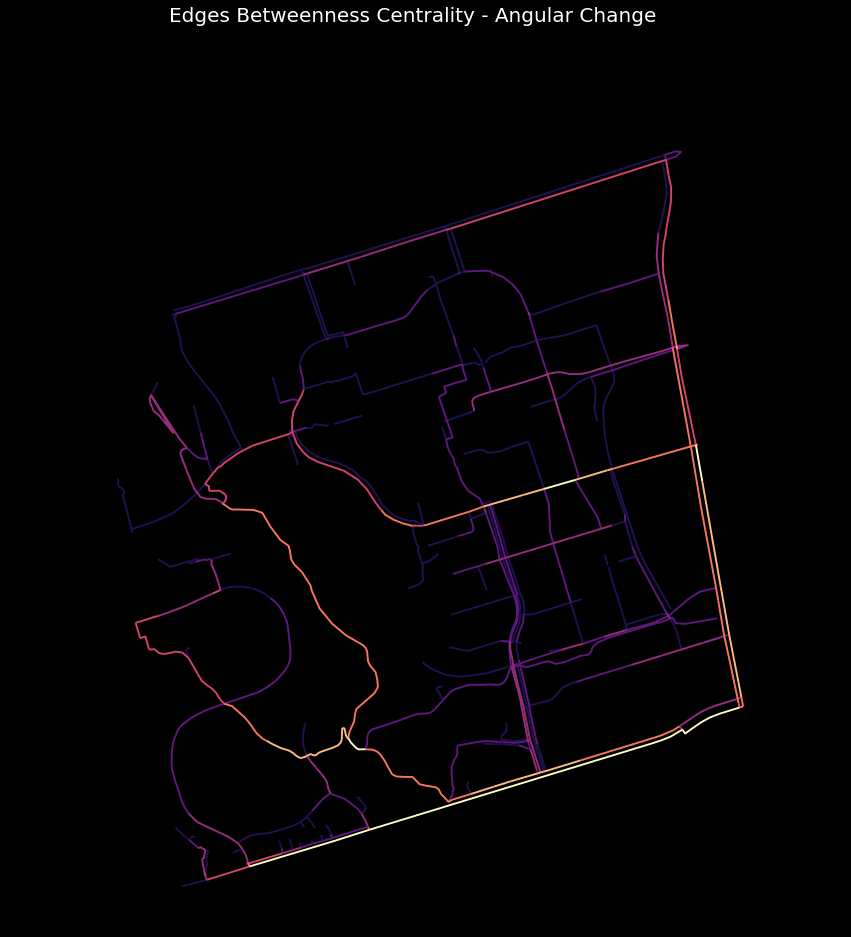

In [26]:
up.plot_lines(edges, classes = 8, column = 'Ab', title = 'Edges Betweenness Centrality - Angular Change', lw = 1.9,
              cmap = 'magma', scheme = 'fisher_jenks', fig_size = 15)

## Districts

Finally, districts are extracted using the Modularity Optimisation Algorithm.

In [27]:
# specify which graph shall be used for the district identification
if option_1: 
    DGb = DGa
    edges_graphB = edges_graphA
else: 
    nodesDual_graphB, edgesDual_graphB = up.dual_gdf(nodes_graphB, edges_graphB, crs)
    DGb = up.get_dual_graph(nodesDual_graphB, edgesDual_graphB)

In [28]:
"""
Different weights are used to extract the partitions. "None" indicates that no weights will be used 
(only topological relationships will matter). The function returns a GeoDataFrame with partitions assigned to edges,
with column named as "p_name_weight" (e.g. "p_length")
 
"""
weights = ['length', 'rad', None]
for i in weights:
    edges_graphB = up.identify_regions(DGb, edges_graphB, weight = i)

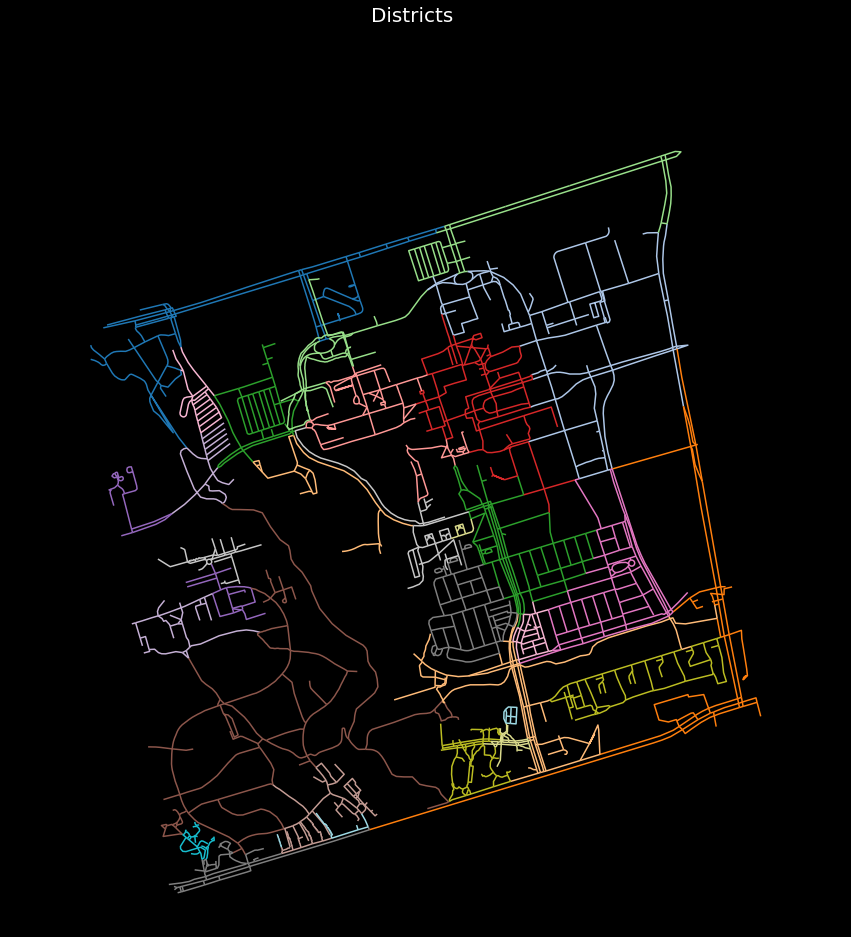

In [29]:
# visualising
up.plot_lines(edges_graphB, column = 'p_rad', title = 'Districts', lw = 1.5, cmap = 'tab20', black_background = True, 
              legend = False, fig_size =15)

## Natural Roads

Finally, before saving, street segments are categorised based on the continuing roads or natural roads approach.
Streets are indeed recognised as entities by an observer in relation to the perception of continuity - a concept adressed already by Lynch himself - rather than for their name.
Continuity is based indeed on the degree of angular change amplitude (continuity tolerance is defined through the tolerance parameter; two segments are never considered continuous if their angle of incidentce is higher than the tolerance).

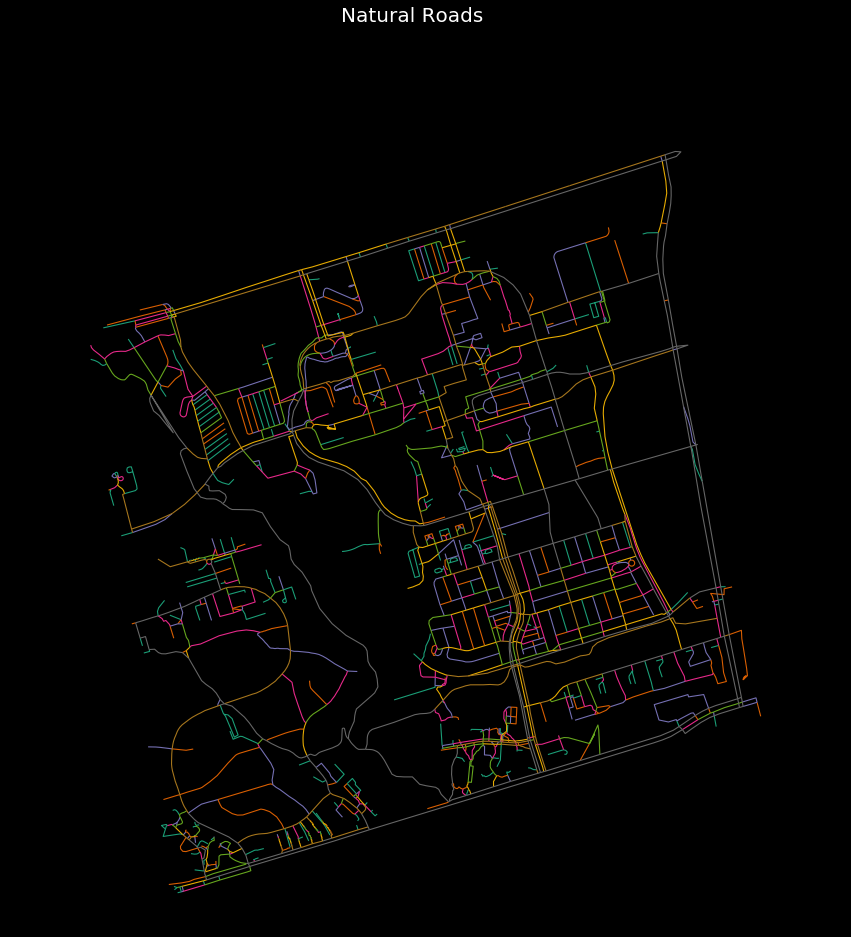

In [33]:
# running natural roads_functions 
edges = up.identify_natural_roads(nodes, edges, tolerance = 45)
# and visualising
up.plot_lines(edges, column = 'naturalID', title = 'Natural Roads', lw = 1.1, cmap = 'Dark2', black_background = True, 
              legend = False, fig_size = 15)

## Saving graphs

In [44]:
# provide path
saving_path = loading_path

In [45]:
nodes.crs = crs
nodes.to_file(saving_path+city_name+'_nodes.shp', driver='ESRI Shapefile')
edges.crs = crs
edges.to_file(saving_path+city_name+'_edges.shp', driver ='ESRI Shapefile')

nodesDual_graphA = nodesDual_graphA.drop('intersecting', axis=1)
nodesDual_graphA.crs = crs
nodesDual_graphA.to_file(saving_path+city_name+'_nodesDual.shp', driver = 'ESRI Shapefile')
edgesDual_graphA.crs = crs
edgesDual_graphA.to_file(saving_path+city_name+'_edgesDual.shp', driver = 'ESRI Shapefile')

In [48]:
# saving districts
districts = edges_graphB
districts.crs = crs
districts.to_file(saving_path+city_name+'_districts.shp', driver = 'ESRI Shapefile')